In [94]:
import cv2 as cv

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

import os
import itertools
import time

sns.set(font_scale=1.4, style="darkgrid", palette='Set2')

In [2]:
path = r"D:\CV\task5\Images"

In [78]:
def match_points(keypoints1, keypoints2, descriptors1, descriptors2, img1, img2, index_params, search_params):
    flann_matcher = cv.FlannBasedMatcher(index_params, search_params)

    matches = flann_matcher.match(descriptors1, descriptors2)
    good_matches = matches
    src_points = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_points = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    homography, mask = cv.findHomography(src_points, dst_points, cv.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    return good_matches, matches_mask


def find_repeats(keypoints_array, descriptors_array, images_array, index_params, search_params):
    dict_points = {}
    dict_indexes = {}
    repeatability = []

    for i in range(1, len(images_array)):
        kp1, des1, img1 = keypoints_array[i], descriptors_array[i], images_array[i]

        for j in range(i):
            kp2, des2, img2 = keypoints_array[j], descriptors_array[j], images_array[j]
            good_matches, matches_mask = match_points(kp1, kp2, des1, des2, img1, img2, index_params, search_params)

            for k, match in enumerate(good_matches):
                if matches_mask[k] != 1:
                    continue

                query_keypoint = kp1[match.queryIdx]
                train_keypoint = kp2[match.trainIdx]

                if train_keypoint in dict_points:
                    dict_points[train_keypoint].append(query_keypoint)
                    dict_indexes[train_keypoint].add(i)
                else:
                    if train_keypoint not in set(itertools.chain(*dict_points.values())):
                        dict_points[train_keypoint] = [query_keypoint]
                        dict_indexes[train_keypoint] = {i, j}
                    else:
                        valkey = next(key for key in dict_points.keys() if train_keypoint in dict_points[key])
                        if query_keypoint not in dict_points[valkey]:
                            dict_points[valkey].append(query_keypoint)
                            dict_indexes[valkey].add(i)

        repeatability.append(sum(len(indexes) / (i + 1) for indexes in dict_indexes.values()) / len(dict_indexes))

    return repeatability, dict_indexes

In [100]:
def calculate_repeatabilities(detector, index_params, search_params):
    image_filenames = os.listdir(path)
    detector_obj = detector()
    
    image_array = [None] * len(image_filenames)
    kp_array = []
    des_array = []
    total_time = 0
    
    for i, image_filename in enumerate(image_filenames):
        image_array[i] = cv.imread(os.path.join(path, image_filename))
        
        time_start = time.time()
        kp, des = detector_obj.detectAndCompute(image_array[i], None)
        time_end = time.time()
        total_time += (time_end - time_start) / len(kp)
        
        kp_array.append(kp)
        des_array.append(des)
    
    time_per_kp = total_time / sum(len(kp) for kp in kp_array)
    
    repeatability, dict_indexes = find_repeats(kp_array, des_array, image_array, index_params, search_params)
    
    return repeatability, dict_indexes, time_per_kp

In [101]:
repeatability_SIFT, dict_indexes_SIFT, SIFT_time = calculate_repeatabilities(cv.xfeatures2d.SIFT_create, 
                                                                              dict(algorithm = 1, 
                                                                                   trees = 5), 
                                                                              dict(checks=50))

repeatability_ORB, dict_indexes_ORB, ORB_time = calculate_repeatabilities(cv.ORB_create, 
                                                                              dict(algorithm = 6, 
                                                                                   table_number = 6,
                                                                                   key_size = 12,     
                                                                                   multi_probe_level = 1),
                                                                              dict(checks=50))

repeatability_BRISK, dict_indexes_BRISK, BRISK_time = calculate_repeatabilities(cv.BRISK_create, 
                                                                              dict(algorithm = 6, 
                                                                                   table_number = 6,
                                                                                   key_size = 12,     
                                                                                   multi_probe_level = 1),
                                                                              dict(checks=50))

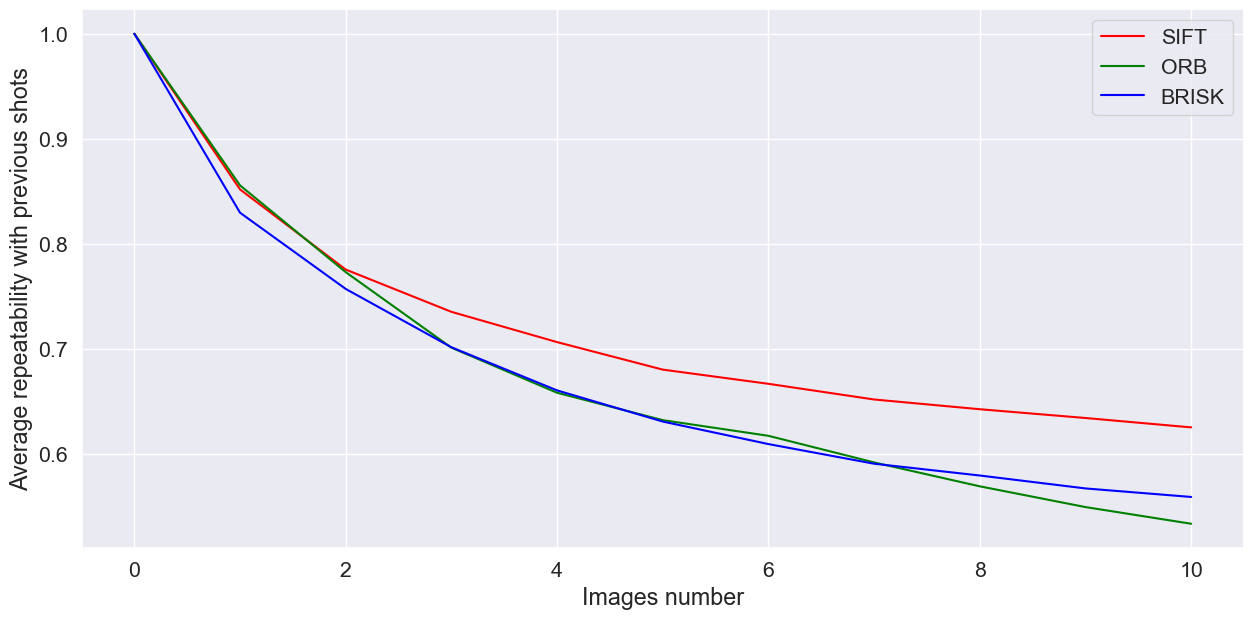

In [99]:
plt.figure(figsize=(15, 7))
plt.plot(repeatability_SIFT, label='SIFT', color='red')  
plt.plot(repeatability_ORB, label='ORB', color='green') 
plt.plot(repeatability_BRISK, label='BRISK', color='blue')
plt.xlabel('Images number')
plt.ylabel('Average repeatability with previous shots')
plt.legend()
plt.show()

In [109]:
print(f'Time taken for one key point: \n ORB: {ORB_time} s, \n SIFT: {SIFT_time} s,\n BRISK: {BRISK_time} s')

Time taken for one key point: 
 ORB: 1.6987850706877395e-08 s, 
 SIFT: 5.097464670762131e-08 s,
 BRISK: 1.607607623928881e-08 s
